# Building a FAISS-Based Vector Store: A Journey Through Data Processing and Visualization

In this notebook, you'll learn how to transform raw PDF documents into a searchable vector store using FAISS. We'll go on a journey where we:

1. **Read and extract text from PDF files.**
2. **Split the text into manageable chunks.**
3. **Display tokenization outputs from different tokenizers.**
4. **Generate embeddings from the text using a SentenceTransformer.**
5. **Store the embeddings in a FAISS index.**
6. **Project the embeddings into 2D space using UMAP for visualization.**
7. **Visualize the entire process on a scatter plot.**
8. **Incect your data into a prompt for a large language model**

In [51]:
import os
import tqdm
import glob
from PyPDF2 import PdfReader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from sentence_transformers import SentenceTransformer
from langchain.text_splitter import SentenceTransformersTokenTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings  # For generating embeddings for text chunks
import faiss
import pickle
import matplotlib.pyplot as plt
import umap.umap_ as umap
import numpy as np
from dotenv import load_dotenv
from groq import Groq


## 1. Reading Data from PDFs

First, we load PDF files from a directory, extract their text content, and combine it into one large text string.

In [52]:
### load the pdf from the path
glob_path = "data/*.pdf"
text = ""
for pdf_path in tqdm.tqdm(glob.glob(glob_path)):
    with open(pdf_path, "rb") as file:
        print(file)
        reader = PdfReader(file)
         # Extract text from all pages in the PDF
        text += " ".join(page.extract_text() for page in reader.pages if page.extract_text())

text[:50]

 11%|█         | 1/9 [00:00<00:01,  7.44it/s]

<_io.BufferedReader name='data\\02_Merkblatt_Vermeidung-von-Plagiaten_0916.pdf'>
<_io.BufferedReader name='data\\05_Checkliste_Sprachliche_Formale_Ausarbeitung.pdf'>


 44%|████▍     | 4/9 [00:00<00:00,  5.67it/s]

<_io.BufferedReader name='data\\Bibliotheksangebot_Bachelorarbeit_HS24FS25.pdf'>
<_io.BufferedReader name='data\\Schwerpunktthemen_fuer_Studenten.pdf'>
<_io.BufferedReader name='data\\W_MB_Merkblatt_Bachelorarbeit_BSc.pdf'>


 56%|█████▌    | 5/9 [00:01<00:01,  3.79it/s]

<_io.BufferedReader name='data\\ZHAW_Zitierleitfaden_DE.pdf'>


 67%|██████▋   | 6/9 [00:01<00:01,  2.49it/s]

<_io.BufferedReader name='data\\Z_MB_Merkblatt_Verwendung_von_generativer_KI_in_Arbeiten.pdf'>


 78%|███████▊  | 7/9 [00:02<00:00,  2.86it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_Anhang_Deklarationspflicht_KI_bei_Arbeiten.pdf'>


 89%|████████▉ | 8/9 [00:02<00:00,  2.54it/s]

<_io.BufferedReader name='data\\Z_RL_Richtlinie_KI_bei_Leistungsnachweisen.pdf'>


100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


' \n \n \n \n \n \n2.2.5.1 -01MB Vermeidung von Plagiaten'

## 2. Splitting the Text into Chunks

Large texts can be difficult to work with. We use a text splitter, in this case [RecursiveCharacterTextSplitter](https://python.langchain.com/docs/how_to/recursive_text_splitter/),  to break the full text into smaller, overlapping chunks. This helps preserve context when we later embed the text.

In [53]:
# Create a splitter: 2000 characters per chunk with an overlap of 200 characters
splitter = RecursiveCharacterTextSplitter(chunk_size=2000, chunk_overlap=200)
# Split the extracted text into manageable chunks
chunks = splitter.split_text(text)

In [54]:
print(f"Total chunks: {len(chunks)}")
print("Preview of the first chunk:", chunks[0][:200])

Total chunks: 61
Preview of the first chunk: 2.2.5.1 -01MB Vermeidung von Plagiaten  Dok.- Verantw.:  mart 
Version 2.0   
. 
Genehmigt  19.9.12  durch: Generalsekretär   Seite 1 von 2 
 Rektorat  
 
Ressort Lehre  
 
Merkblatt zur Vermeidung vo


## 3. Tokenizing the Text with Different Tokenizers

Before embedding, it's insightful to see how different tokenizers break up our text. Here, we use the tokenizer from the SentenceTransformer model (see [SentenceTransformersTokenTextSplitter](https://python.langchain.com/api_reference/text_splitters/sentence_transformers/langchain_text_splitters.sentence_transformers.SentenceTransformersTokenTextSplitter.html#sentencetransformerstokentextsplitter)).

In [55]:
token_splitter = SentenceTransformersTokenTextSplitter(chunk_overlap=0, tokens_per_chunk=128, model_name="paraphrase-multilingual-MiniLM-L12-v2")

In [56]:
token_split_texts = []
for text in chunks:
    token_split_texts += token_splitter.split_text(text)

print(f"\nTotal chunks: {len(token_split_texts)}")
print(token_split_texts[0])


Total chunks: 252
2.2.5.1 -01MB Vermeidung von Plagiaten Dok.- Verantw.: mart Version 2.0 . Genehmigt 19.9.12 durch: Generalsekretär Seite 1 von 2 Rektorat Ressort Lehre Merkblatt zur Vermeidung von Plagiaten Plagiate verstossen gegen grundlegende Regeln wissenschaftlichen Arbeitens. Entsprechend s e- hen das Gesetz und die Rahmenprüfungsordnung für Bachelor - und Masterstudi engänge der ZHAW (RPO) in Plagiatsfällen zum Teil gravierende Sanktionen für Studierende vor. Dieses Mer k- blatt soll 


In [57]:
model_name = "paraphrase-multilingual-MiniLM-L12-v2"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['<s>', '▁2.2', '.', '5.1', '▁', '-01', 'MB', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Dok', '.', '-', '▁Ver', 'ant', 'w', '.', ':', '▁mart', '▁Version', '▁2.0', '▁', '.', '▁Ge', 'nehm', 'igt', '▁19', '.9.', '12', '▁durch', ':', '▁General', 'sekretär', '▁Seite', '▁1', '▁von', '▁2', '▁Rektor', 'at', '▁Res', 'sort', '▁Lehr', 'e', '▁Merk', 'blatt', '▁zur', '▁Verme', 'i', 'dung', '▁von', '▁Pla', 'gia', 'ten', '▁Pla', 'gia', 'te', '▁vers', 'to', 'ssen', '▁gegen', '▁grundlegende', '▁Regeln', '▁', 'wissenschaftlich', 'en', '▁Arbeiten', 's', '.', '▁Ent', 'sprechen', 'd', '▁s', '▁e', '-', '▁hen', '▁das', '▁Gesetz', '▁und', '▁die', '▁Rahmen', 'prüfung', 's', 'ordnung', '▁für', '▁Bachelor', '▁-', '▁und', '▁Master', 'studi', '▁en', 'gänge', '▁der', '▁Z', 'HA', 'W', '▁(', 'R', 'PO', ')', '▁in', '▁Pla', 'gia', 'ts', 'fälle', 'n', '▁zum', '▁Teil', '▁gravi', 'erende', '▁San', 'ktion', 'en', '▁für', '▁Studi', 'erende', '▁vor', '.', '▁Dieses', '▁Mer', '▁k', '-', '▁', 'blatt', '</s

In [58]:
model_name = "Sahajtomar/German-semantic"
model = SentenceTransformer(model_name)
tokenized_chunks = []
for i, text in enumerate(token_split_texts[:10]):
    # Tokenize each chunk
    encoded_input = model.tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors='pt')
    # Convert token IDs back to tokens
    tokens = model.tokenizer.convert_ids_to_tokens(encoded_input['input_ids'][0].tolist())
    tokenized_chunks.append(tokens)
    print(f"Chunk {i}: {tokens}")

Chunk 0: ['[CLS]', '2', '.', '2', '.', '5', '.', '1', '-', '01', '##MB', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Dok', '.', '-', 'Veran', '##tw', '.', ':', 'mar', '##t', 'Version', '2', '.', '0', '.', 'Genehm', '##igt', '19', '.', '9', '.', '12', 'durch', ':', 'Generalsekretär', 'Seite', '1', 'von', '2', 'Rektor', '##at', 'Ressort', 'Lehre', 'Merk', '##blatt', 'zur', 'Vermeidung', 'von', 'Pla', '##gia', '##ten', 'Pla', '##gia', '##te', 'verst', '##ossen', 'gegen', 'grundlegende', 'Regeln', 'wissenschaft', '##lichen', 'Arbeiten', '##s', '.', 'Entsprechend', 's', 'e', '-', 'hen', 'das', 'Gesetz', 'und', 'die', 'Rahmen', '##prüfung', '##sor', '##dn', '##ung', 'für', 'Bachelor', '-', 'und', 'Masters', '##tu', '##di', 'eng', '##änge', 'der', 'Z', '##H', '##AW', '(', 'R', '##PO', ')', 'in', 'Pla', '##gia', '##ts', '##fällen', 'zum', 'Teil', 'grav', '##ierende', 'Sanktionen', 'für', 'Studierende', 'vor', '.', 'Dieses', 'Mer', 'k', '-', 'bl', '##att', 'soll', '[SEP]']
Chunk 1: ['[CLS]',

## 4. Generating Embeddings for Each Chunk

Now we convert each text chunk into a numerical embedding that captures its semantic meaning. These embeddings will be used for similarity search.

In [59]:
embeddings = HuggingFaceEmbeddings(model_name="paraphrase-multilingual-MiniLM-L12-v2")
chunk_embeddings = model.encode(token_split_texts, convert_to_numpy=True)

## 5. Building a FAISS Vector Store

FAISS is a powerful library for efficient similarity search. Here, we build an index from our embeddings. Remember, FAISS only stores the numerical vectors so we must keep our original text mapping separately.

In [60]:
d = chunk_embeddings.shape[1]
print(d)

1024


In [61]:
index = faiss.IndexFlatL2(d)
index.add(chunk_embeddings)
print("Number of embeddings in FAISS index:", index.ntotal)

Number of embeddings in FAISS index: 252


In [62]:
if not os.path.exists('faiss'):
    os.makedirs('faiss')
    
faiss.write_index(index, "faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "wb") as f:
    pickle.dump(chunks, f)

In [63]:
index_2 = faiss.read_index("faiss/faiss_index.index")
with open("faiss/chunks_mapping.pkl", "rb") as f:
    token_split_texts_2 = pickle.load(f)
print(len(token_split_texts_2))
print(len(token_split_texts))

61
252


## 6. Projecting Embeddings with UMAP

To visualize high-dimensional embeddings, we use UMAP to project them into 2D space. You can project both the entire dataset and individual query embeddings.

In [64]:
# Fit UMAP on the full dataset embeddings
umap_transform = umap.UMAP(random_state=0, transform_seed=0).fit(chunk_embeddings)

def project_embeddings(embeddings, umap_transform):
    """
    Project a set of embeddings using a pre-fitted UMAP transform.
    """
    umap_embeddings = np.empty((len(embeddings), 2))
    for i, embedding in enumerate(tqdm.tqdm(embeddings, desc="Projecting Embeddings")):
        umap_embeddings[i] = umap_transform.transform([embedding])
    return umap_embeddings


c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


In [65]:
# Project the entire dataset embeddings
projected_dataset_embeddings = project_embeddings(chunk_embeddings, umap_transform)
print("Projected dataset embeddings shape:", projected_dataset_embeddings.shape)

Projecting Embeddings:   0%|          | 0/252 [00:00<?, ?it/s]c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\en

Projected dataset embeddings shape: (252, 2)


## 7. Querying the Vector Store and Projecting Results

We now define a retrieval function that takes a text query, embeds it, and searches our FAISS index for similar documents. We then project these result embeddings with UMAP.
"""

In [66]:
def retrieve(query, k=5):
    """
    Retrieve the top k similar text chunks and their embeddings for a given query.
    """
    query_embedding = model.encode([query], convert_to_numpy=True)
    distances, indices = index.search(query_embedding, k)
    retrieved_texts = [token_split_texts[i] for i in indices[0]]
    retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])
    return retrieved_texts, retrieved_embeddings, distances[0]

In [67]:
query = "KI während der Bachelorarbeit"
results, result_embeddings, distances = retrieve(query, k=3)
print("Retrieved document preview:")
print(results[0][:300])

Retrieved document preview:
(2012). Die Chefs von morgen: Kompetent und kritisch. io Management, 2012(5), 12-15. Zitierleitfaden | 19 Zitierleitfaden | 20 Generative Systeme, die auf Künstlicher Intelligenz (KI) basieren, gehören zunehmend zur neuen Studien- und Berufsrealität von Lehrenden und Lernenden. Die Richtlinie KI bei


In [68]:
# Project the result embeddings
projected_result_embeddings = project_embeddings(result_embeddings, umap_transform)

# Also embed and project the original query for visualization
query_embedding = model.encode([query], convert_to_numpy=True)
project_original_query = project_embeddings(query_embedding, umap_transform)

Projecting Embeddings:   0%|          | 0/3 [00:00<?, ?it/s]c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
Projecting Embeddings:   0%|          | 0/1 [00:00<?, ?it/s]c:\Users\gs\AppData\Local\anaconda3\envs\rag-kernel\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.

## 8. Visualizing the Results

Finally, we create a scatter plot to visualize the entire dataset, the retrieved results, and the original query in 2D space.

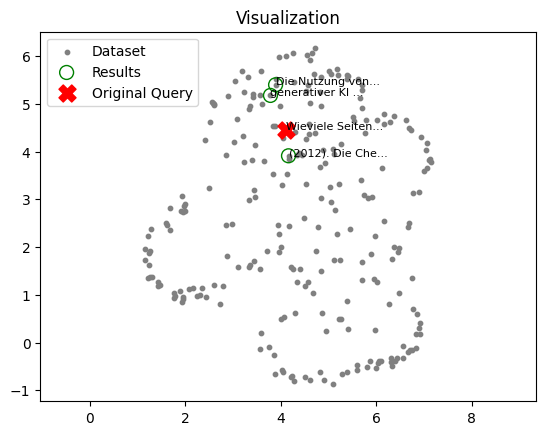

In [69]:

def shorten_text(text, max_length=15):
    """Shortens text to max_length and adds an ellipsis if shortened."""
    return (text[:max_length] + '...') if len(text) > max_length else text

plt.figure()

# Scatter plots
plt.scatter(projected_dataset_embeddings[:, 0], projected_dataset_embeddings[:, 1],
            s=10, color='gray', label='Dataset')
plt.scatter(projected_result_embeddings[:, 0], projected_result_embeddings[:, 1],
            s=100, facecolors='none', edgecolors='g', label='Results')
plt.scatter(project_original_query[:, 0], project_original_query[:, 1],
            s=150, marker='X', color='r', label='Original Query')

# If results is a list of texts, iterate directly
for i, text in enumerate(results):
    if i < len(projected_result_embeddings):
        plt.annotate(shorten_text(text),
                     (projected_result_embeddings[i, 0], projected_result_embeddings[i, 1]),
                     fontsize=8)

# Annotate the original query point
original_query_text = 'Welche hilfsmittel sind erlaubt?'  # Replace with your actual query text if needed
original_query_text = 'Wieviele Seiten muss die Arbeit sein?'  # Replace with your actual query text if needed

plt.annotate(shorten_text(original_query_text),
             (project_original_query[0, 0], project_original_query[0, 1]),
             fontsize=8)

plt.gca().set_aspect('equal', 'datalim')
plt.title('Visualization')
plt.legend()
plt.show()


---

# 📝 Task: Semantic Retrieval-Augmented Question Answering Using Groq LLM

## Objective
Implement a question-answering system that:
1. Retrieves the most semantically relevant text passages to a user query.
2. Constructs a natural language prompt based on the retrieved content.
3. Uses a large language model (LLM) hosted by Groq to generate an answer.

---

## Task Breakdown

### 1. Embedding-Based Semantic Retrieval
- Use the `SentenceTransformer` model `"Sahajtomar/German-semantic"` to encode a user query into a dense vector embedding.
- Perform a nearest-neighbor search in a prebuilt FAISS index to retrieve the top-**k** similar text chunks. You can **use the prebuilt FAISS form above**.


### 2. LLM Prompt Construction and Query Answering
- Build the prompt:
  - Using the retrieved text chunks, concatenates the results into a context block.
  - Builds a **prompt** asking the LLM to answer the question using that context.
  - Sends the prompt to the **Groq LLM API** (`llama-3.3-70b-versatile`) and returns the response.

### 3. User Query Execution
- An example query (`"What is the most important factor in diagnosing asthma?"`) is used to demonstrate the pipeline.
- The final answer from the LLM is printed.


## Tools & Models Used
- **SentenceTransformers** (`Sahajtomar/German-semantic`) for embedding generation.
- **FAISS** for efficient vector similarity search.
- **Groq LLM API** (`llama-3.3-70b-versatile`) for generating the final response.


In [70]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

In [71]:
load_dotenv()
# Access the API key using the variable name defined in the .env file
groq_api_key = os.getenv("GROQ_API_KEY")

#load SentenceTransformer model
model = SentenceTransformer("Sahajtomar/German-semantic")

In [72]:
# Example query
query = "Wie müssen KI-generierte Inhalte in einer Arbeit gekennzeichnet werden?"
query_embedding = model.encode(query, convert_to_numpy=True)

# Retrieve similar chunks
k=3
query_vector = np.array([query_embedding], dtype="float32")

# Search in Index
distances, indices = index.search(query_vector, k)

# Extract matching chunks
retrieved_texts = [token_split_texts[i] for i in indices[0]]
retrieved_embeddings = np.array([chunk_embeddings[i] for i in indices[0]])


# Print matching chunks
for i, text in enumerate(retrieved_texts):
    print(f"--- Match {i+1} ---\n{text[:300]}...\n")

--- Match 1 ---
tiven KI -Systemen sind die fachspezifische n Zitierregeln einzuhalten. − Bei der (Weiter -)Bearbeitung eigener Daten oder bereits generiertem Output durch generative KI -Systeme sind die verwendeten Werkzeuge unter Angabe des Verwendungszwecks summarisch in der Arbeit aufzulisten, z.B. in einem Ver...

--- Match 2 ---
zielführend noch praktikabel. Im Sinne der Eigenleistung bzw. wissenschaftlichen Integrität muss die Ver - wendung von KI jedoch bestmöglich transparent gemacht werden. Grundsätzlich gilt daher eine Deklarationspflicht für alle generativen KI-Systeme, welche die Qualität einer Arbeit auf inhaltli- c...

--- Match 3 ---
Generative KI -Systeme müssen wie andere Hilfsmittel und Quellen angegeben werden, wenn Output (vgl. zur Definition Ziff. 5 RL KI) in die Arbeit eingearbeitet wird . Der Ante il bzw. das Aus- mass des Mitwirkens von generativen KI -Systemen an der schöpferischen Leistung einer Arbeit muss für Dritte...



In [73]:
# Create prompt
context = "\n\n".join(retrieved_texts)
prompt = f"""Answer the following question based on the provided context.

Question:
{query}

Context:
{context}
"""
print(prompt[:1500]) 

Answer the following question based on the provided context.

Question:
Wie müssen KI-generierte Inhalte in einer Arbeit gekennzeichnet werden?

Context:
tiven KI -Systemen sind die fachspezifische n Zitierregeln einzuhalten. − Bei der (Weiter -)Bearbeitung eigener Daten oder bereits generiertem Output durch generative KI -Systeme sind die verwendeten Werkzeuge unter Angabe des Verwendungszwecks summarisch in der Arbeit aufzulisten, z.B. in einem Verzeichnis.

zielführend noch praktikabel. Im Sinne der Eigenleistung bzw. wissenschaftlichen Integrität muss die Ver - wendung von KI jedoch bestmöglich transparent gemacht werden. Grundsätzlich gilt daher eine Deklarationspflicht für alle generativen KI-Systeme, welche die Qualität einer Arbeit auf inhaltli- cher Ebene beeinflussen. Für diesen Zitierleitfaden sind folgende Punkte relevant: − Eine wortwörtliche, paraphrasierende oder sinngemässe Übernahme von Output aus gene- rativen KI-Systemen muss in einer Arbeit an der entsprechenden Ste

In [74]:
# Config for Groq
from dotenv import load_dotenv
from openai import OpenAI
import os

# .env laden
load_dotenv()

# API-Key auslesen und prüfen
key = os.getenv("GROQ_API_KEY")
print("KEY GEFUNDEN:", key[:10] + "..." if key else "NICHT GEFUNDEN")

# Groq-Client initialisieren
client = OpenAI(
    api_key=key,
    base_url="https://api.groq.com/openai/v1"
)

# Prompt definieren
prompt = "Darf ich KI-generierte Inhalte in meiner Bachelorarbeit verwenden?"

# Anfrage senden
response = client.chat.completions.create(
    model="llama3-70b-8192",  # Groq verwendet exakt diesen Modellnamen!
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0,
    max_tokens=200
)

# Antwort ausgeben
answer = response.choices[0].message.content
print("Antwort:\n")
print(answer)


KEY GEFUNDEN: gsk_1Bnoy6...
Antwort:

What a great question!

In general, it's allowed to use AI-generated content in your bachelor's thesis, but there are some important considerations to keep in mind:

1. **Transparency**: You must clearly indicate which parts of your thesis were created with the help of AI tools, such as language generators, image generators, or other AI-powered software. This is essential to maintain academic integrity and avoid plagiarism.
2. **Originality**: While AI-generated content can be useful, it's crucial to ensure that your thesis still reflects your own original ideas, analysis, and contributions. AI-generated content should supplement your work, not replace it.
3. **Quality control**: Verify the accuracy and quality of the AI-generated content. AI tools can make mistakes, and it's your responsibility to fact-check and correct any errors.
5. **Citation and referencing**: If you use AI-generated content, you should cite the AI tool or model used, as well 

In [75]:
# Example query
query = "Darf KI in einer Arbeit verwendet werden?"
# Embed the query
query_embedding = model.encode(query, convert_to_numpy=True)
# Retrieve similar chunks
query_vector = np.array([query_embedding], dtype="float32")
distances, indices = index.search(query_vector, k=3)
# Extract matching chunks
retrieved_texts = [token_split_texts[i] for i in indices[0]]
# Create prompt
context = "\n".join(retrieved_texts)
prompt = f"""Answer the following question based on the provided context.

Question:
{query}

Context:
{context}
"""
# Send to LLM API
response = client.chat.completions.create(
    model="llama3-70b-8192",
    messages=[
        {"role": "user", "content": prompt}
    ],
    temperature=0,
    max_tokens=200,
    top_p=1,
    frequency_penalty=0,
    presence_penalty=0
)

# Display response
answer = response.choices[0].message.content
print("Antwort:\n")
print(answer)

Antwort:

Based on the provided context, the answer to the question "Darf KI in einer Arbeit verwendet werden?" (Can AI be used in a work?) is:

Ja, aber unter bestimmten Bedingungen (Yes, but under certain conditions).

According to the text, there is no blanket ban on the use of generative KI systems in works, but rather, certain conditions must be met, such as ensuring that the system does not use input data as training data, and that it is only used as a tool to assist with open-ended tasks.
